In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os

from torch import nn
from torchvision import transforms
from utils import set_seeds, train, plot_loss_curves

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ["anger", "disgust", "fear", "happy", "pain", "sad"]

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [4]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

d:\Anaconda\envs\venvSD\lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [5]:
# Setup directory paths to train and test images
train_dir = os.getcwd().replace('\\','/') + '/archive/train'
test_dir = os.getcwd().replace('\\','/') + '/archive/test'

In [6]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [8]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [9]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4716 | train_acc: 0.4518 | test_loss: 1.2107 | test_acc: 0.5317
Epoch: 2 | train_loss: 1.0694 | train_acc: 0.6465 | test_loss: 1.0553 | test_acc: 0.5765
Epoch: 3 | train_loss: 0.9297 | train_acc: 0.7000 | test_loss: 1.0063 | test_acc: 0.6053
Epoch: 4 | train_loss: 0.8353 | train_acc: 0.7301 | test_loss: 0.9779 | test_acc: 0.6287
Epoch: 5 | train_loss: 0.7660 | train_acc: 0.7615 | test_loss: 0.9784 | test_acc: 0.6390
Epoch: 6 | train_loss: 0.7089 | train_acc: 0.7815 | test_loss: 0.9378 | test_acc: 0.6365
Epoch: 7 | train_loss: 0.6624 | train_acc: 0.7980 | test_loss: 0.9506 | test_acc: 0.6390
Epoch: 8 | train_loss: 0.6237 | train_acc: 0.8146 | test_loss: 0.9325 | test_acc: 0.6521
Epoch: 9 | train_loss: 0.5832 | train_acc: 0.8328 | test_loss: 0.9240 | test_acc: 0.6365
Epoch: 10 | train_loss: 0.5573 | train_acc: 0.8422 | test_loss: 0.9009 | test_acc: 0.6887
Epoch: 11 | train_loss: 0.5237 | train_acc: 0.8521 | test_loss: 0.9081 | test_acc: 0.6521
Epoch: 12 | train_l

In [10]:
torch.save(pretrained_vit.state_dict(), "pretrained_vit_weight.pt")

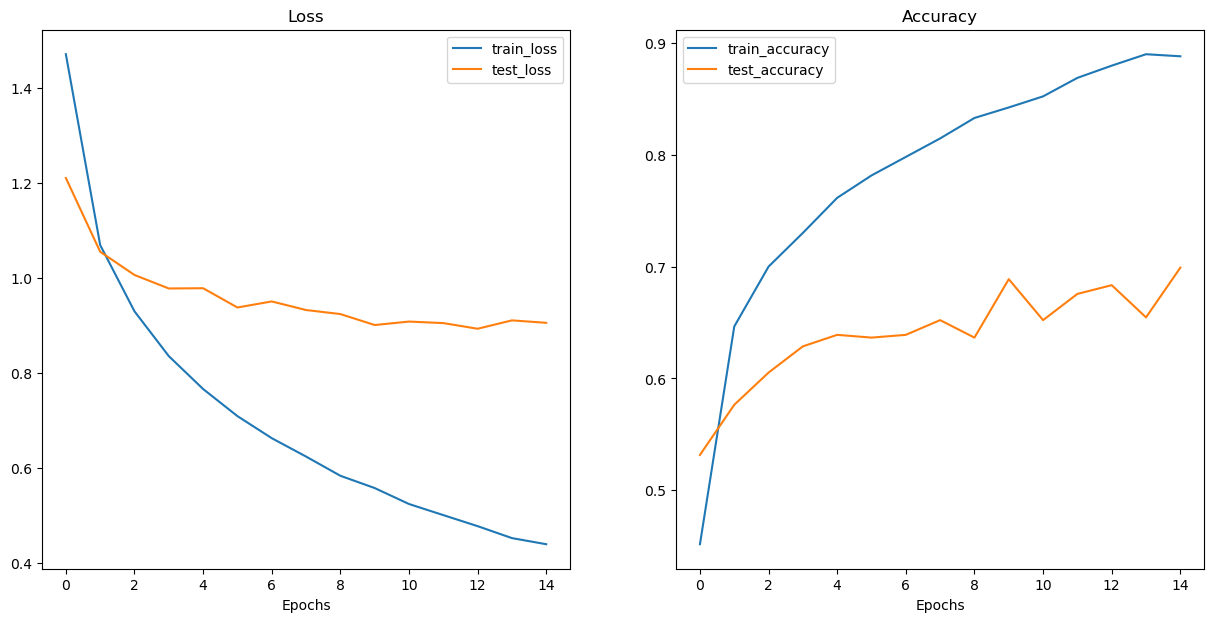

In [11]:
plot_loss_curves(pretrained_vit_results)